<a href="https://www.kaggle.com/code/adityarai12/alzheimer-disease-prediction-ensemble-model?scriptVersionId=198799663" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

STATE PATH AND RESIZE IMAGES

In [4]:
X_train = []
Y_train = []
image_size = 150
labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation by up to 10 degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10%
    height_shift_range=0.1,  # Random vertical shift by up to 10%
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Random zoom by up to 20%
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for points outside the input boundaries
)

# Reshape the input data to (num_samples, height, width, channels)
X_train = X_train.reshape(-1, image_size, image_size, 3)

# Apply data augmentation
augmented_data = []
for img in X_train:
    # Reshape the image to (1, height, width, channels) for flow method
    img = img.reshape((1,) + img.shape)
    # Generate augmented images
    augmented_images = datagen.flow(img, batch_size=1)
    # Append augmented images to the list
    for _ in range(5):  # Augment each image 5 times
        augmented_data.append(augmented_images.next()[0])

# Concatenate original and augmented data
X_train_augmented = np.concatenate([X_train, augmented_data], axis=0)
Y_train_augmented = np.concatenate([Y_train] * 6, axis=0)  # Multiply by 6 to match the augmented data


In [6]:
X_train , Y_train = shuffle(X_train, Y_train, random_state = 101)
X_train.shape
# X_train_augmented.shape

(6400, 150, 150, 3)

In [7]:
X_train , X_test , y_train , y_test = train_test_split(X_train,Y_train, test_size=0.1 , random_state=101)

In [8]:
Y_train_augmented


array(['MildDemented', 'MildDemented', 'MildDemented', ...,
       'VeryMildDemented', 'VeryMildDemented', 'VeryMildDemented'],
      dtype='<U16')

COVERSION OF STATES TO INDEX

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

CONVOLUTIONAL NEURAL NETWORK

RESNET ARCHITECTURE

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model
res_model = Sequential()

# Add the pre-trained ResNet50 model as the first layer
res_model.add(resnet_model)

# Add additional layers
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))

res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(4, activation='softmax'))

# Apply data augmentation
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Compile the model
res_model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final1 = res_model.fit(
                  X_train,y_train,  
                 epochs=40,
                  batch_size=32,
                  validation_split=0.1
)




94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/40
162/162 [==============================] - 15s 42ms/step - loss: 2.6047 - accuracy: 0.3252 - val_loss: 1.7444 - val_accuracy: 0.4375
Epoch 2/40
162/162 [==============================] - 6s 35ms/step - loss: 2.2927 - accuracy: 0.3812 - val_loss: 1.6371 - val_accuracy: 0.4705
Epoch 3/40
162/162 [==============================] - 6s 35ms/step - loss: 2.1027 - accuracy: 0.4196 - val_loss: 1.5179 - val_accuracy: 0.5556
Epoch 4/40
162/162 [==============================] - 6s 35ms/step - loss: 1.9635 - accuracy: 0.4549 - val_loss: 1.3799 - val_accuracy: 0.6076
Epoch 5/40
162/162 [==============================] - 6s 35ms/step - loss: 1.8380 - accuracy: 0.4857 - val_loss: 1.3195 - val_accuracy: 0.6267
Epoch 6/40
162/162 [==============================] - 6s 35ms/step - loss: 1.7647 - accuracy: 0.4975 - val_loss: 1.3039 - val_accuracy: 0.6302
Epoch 7/40
162/162 [==============================] - 6s 35ms/step - loss: 1

DENSENET ARCHITECTURE


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load pre-trained DenseNet121 model
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in densenet_model.layers:
    layer.trainable = False

# Create a new model
ensenet_model = Sequential()

# Add the pre-trained DenseNet121 model as the first layer
ensenet_model.add(densenet_model)

# Add additional layers with L2 regularization
ensenet_model.add(Flatten())
ensenet_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(4, activation='softmax'))

# Compile the model with Adam optimizer
ensenet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model with early stopping and learning rate scheduler
final2 = ensenet_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, lr_scheduler]
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
162/162 [==============================] - 17s 49ms/step - loss: 2.9252 - accuracy: 0.2828 - val_loss: 2.0217 - val_accuracy: 0.4479 - lr: 1.0000e-05
Epoch 2/100
162/162 [==============================] - 6s 34ms/step - loss: 2.6946 - accuracy: 0.3376 - val_loss: 2.0041 - val_accuracy: 0.4271 - lr: 1.0000e-05
Epoch 3/100
162/162 [==============================] - 5s 33ms/step - loss: 2.5577 - accuracy: 0.3609 - val_loss: 2.0383 - val_accuracy: 0.4392 - lr: 1.0000e-05
Epoch 4/100
162/162 [==============================] - 6s 34ms/step - loss: 2.4808 - accuracy: 0.3839 - val_loss: 1.8285 - val_accuracy: 0.5122 - lr: 1.0000e-05
Epoch 5/100
162/162 [==============================] - 5s 33ms/step - loss: 2.3764 - accuracy: 0.3900 - val_loss: 1.9948 - val_accuracy: 0.4462 - lr: 1.0000e-05
Epoch 6/100
162/162 [==============================] - 5s 33ms/step - loss: 2.3011 - accuracy: 0.4035 - val_loss: 1.8655 - val_ac

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load pre-trained DenseNet121 model
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in densenet_model.layers:
    layer.trainable = False

from tensorflow.keras.regularizers import l2

# Create a new model
ensenet_model = Sequential()

# Add the pre-trained DenseNet121 model as the first layer
ensenet_model.add(densenet_model)

# Add additional layers with L2 regularization
ensenet_model.add(Flatten())
ensenet_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Add L2 regularization
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Add L2 regularization
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(4, activation='softmax'))

# Compile the model with Adam optimizer
ensenet_model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
final2 = ensenet_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/100
162/162 [==============================] - 15s 46ms/step - loss: 2.9302 - accuracy: 0.3059 - val_loss: 2.0938 - val_accuracy: 0.4219
Epoch 2/100
162/162 [==============================] - 5s 33ms/step - loss: 2.6893 - accuracy: 0.3584 - val_loss: 2.0749 - val_accuracy: 0.4670
Epoch 3/100
162/162 [==============================] - 5s 33ms/step - loss: 2.5596 - accuracy: 0.3816 - val_loss: 2.0692 - val_accuracy: 0.4531
Epoch 4/100
162/162 [==============================] - 5s 33ms/step - loss: 2.4675 - accuracy: 0.4030 - val_loss: 2.0970 - val_accuracy: 0.4288
Epoch 5/100
162/162 [==============================] - 5s 33ms/step - loss: 2.3683 - accuracy: 0.4157 - val_loss: 1.8408 - val_accuracy: 0.5330
Epoch 6/100
162/162 [==============================] - 5s 33ms/step - loss: 2.2946 - accuracy: 0.4246 - val_loss: 1.8208 - val_accuracy: 0.5330
Epoch 7/100
162/162 [==============================] - 5s 33ms/step - loss: 2.2424 - accuracy: 0.4412 - val_loss: 1.6384 - val_accuracy

MOBILENET ARCHITECTURE

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load pre-trained MobileNetV2 model
mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Create a new model
e_model = Sequential()

# Add the pre-trained MobileNetV2 model as the first layer
e_model.add(mobilenet_model)

# Add additional layers with L2 regularization
e_model.add(Flatten())
e_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(4, activation='softmax'))

# Compile the model with a lower learning rate
e_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model with data augmentation
final_mob = e_model.fit(
    X_train, y_train,  # Replace with your training data
    epochs=100,
    batch_size=32,
    validation_split=0.1
)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
162/162 [==============================] - 9s 23ms/step - loss: 2.8875 - accuracy: 0.3092 - val_loss: 2.0306 - val_accuracy: 0.4844
Epoch 2/100
162/162 [==============================] - 3s 17ms/step - loss: 2.6461 - accuracy: 0.3611 - val_loss: 1.8680 - val_accuracy: 0.5330
Epoch 3/100
162/162 [==============================] - 3s 17ms/step - loss: 2.4755 - accuracy: 0.3949 - val_loss: 1.8559 - val_accuracy: 0.5469
Epoch 4/100
162/162 [==============================] - 3s 17ms/step - loss: 2.3853 - accuracy: 0.4076 - val_loss: 1.9342 - val_accuracy: 0.4913
Epoch 5/100
162/162 [==============================] - 3s 17ms/step - loss: 2.3014 - accuracy: 0.4259 - val_loss: 1.7382 - val_accuracy: 0.5260
Epoch 6/100
162/162 [==============================] - 3s 17ms/step - loss: 2.2171 - accuracy: 0.4288 - val_loss: 1.6657 - val_accuracy: 0.5625
Epoch 7/100
162/162 [==============================] - 3s 17ms/step - los

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNetV2 model
mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Create a new model
e_model = Sequential()

# Add the pre-trained MobileNetV2 model as the first layer
e_model.add(mobilenet_model)

# Add additional layers
e_model.add(Flatten())
e_model.add(Dense(256, activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(256, activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(4, activation='softmax'))

# Compile the model
e_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final_mob = e_model.fit(
    X_train, y_train,  # Replace with your training data
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/15
162/162 [==============================] - 8s 24ms/step - loss: 1.5468 - accuracy: 0.4512 - val_loss: 1.1677 - val_accuracy: 0.5781
Epoch 2/15
162/162 [==============================] - 3s 17ms/step - loss: 1.1321 - accuracy: 0.5328 - val_loss: 0.9044 - val_accuracy: 0.5972
Epoch 3/15
162/162 [==============================] - 3s 17ms/step - loss: 0.9565 - accuracy: 0.5698 - val_loss: 0.8542 - val_accuracy: 0.6042
Epoch 4/15
162/162 [==============================] - 3s 16ms/step - loss: 0.8683 - accuracy: 0.6111 - val_loss: 0.8717 - val_accuracy: 0.6128
Epoch 5/15
162/162 [==============================] - 3s 17ms/step - loss: 0.8109 - accuracy: 0.6402 - val_loss: 0.8463 - val_accuracy: 0.6302
Epoch 6/15
162/162 [==============================] - 3s 16ms/step - loss: 0.7570 - accuracy: 0.6644 - val_loss: 0.8911 - val_accuracy: 0.6215
Epoch 7/15
162/162 [==============================] - 3s 17ms/step - loss: 0.7088 - accuracy: 0.6927 - val_loss: 0.8380 - val_accuracy: 0.6146

In [15]:
from tensorflow.keras.models import Model

# Get the output tensors of both models
resnet_output = res_model.layers[-1].output
densenet_output = ensenet_model.layers[-1].output
mobilenet_output = e_model.layers[-1].output

# Average the predictions from both models
ensemble_output = tf.keras.layers.average([resnet_output, densenet_output, mobilenet_output])

# Create the ensemble model
ensemble_model = Model(inputs=[res_model.input, ensenet_model.input, e_model.input], outputs=ensemble_output)


ENSEMBLE MODEL PERFORMANCE

In [16]:
# Assuming you have test data: X_test and y_test

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the ensemble model on test data
_, accuracy = ensemble_model.evaluate([X_test, X_test, X_test], y_test)  # Assuming you have X_test and y_test

print("Ensemble Model Accuracy:", accuracy)


20/20 [==============================] - 8s 72ms/step - loss: 0.8380 - accuracy: 0.9250
Ensemble Model Accuracy: 0.925000011920929


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have test data: X_test and y_test

# Predictions of individual models
resnet_predictions = res_model.predict(X_test)
densenet_predictions = ensenet_model.predict(X_test)
mobilenet_predictions = e_model.predict(X_test)

# Ensemble predictions
ensemble_predictions = ensemble_model.predict([X_test, X_test, X_test])

# Convert predictions to class labels
resnet_labels = np.argmax(resnet_predictions, axis=1)
densenet_labels = np.argmax(densenet_predictions, axis=1)
mobilenet_labels = np.argmax(mobilenet_predictions, axis=1)
ensemble_labels = np.argmax(ensemble_predictions, axis=1)

# Convert true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix for individual models
resnet_cm = confusion_matrix(y_true_labels, resnet_labels)
densenet_cm = confusion_matrix(y_true_labels, densenet_labels)
mobilenet_cm = confusion_matrix(y_true_labels, mobilenet_labels)

# Confusion matrix for ensemble model
ensemble_cm = confusion_matrix(y_true_labels, ensemble_labels)

# Classification report for individual models
print("ResNet Classification Report:")
print(classification_report(y_true_labels, resnet_labels, target_names=labels))

print("DenseNet Classification Report:")
print(classification_report(y_true_labels, densenet_labels, target_names=labels))

print("MobileNet Classification Report:")
print(classification_report(y_true_labels, mobilenet_labels, target_names=labels))

# Classification report for ensemble model
print("Ensemble Model Classification Report:")
print(classification_report(y_true_labels, ensemble_labels, target_names=labels))

from sklearn.metrics import accuracy_score

# Calculate accuracy score for each class
resnet_accuracy = accuracy_score(y_true_labels, resnet_labels)
densenet_accuracy = accuracy_score(y_true_labels, densenet_labels)
mobilenet_accuracy = accuracy_score(y_true_labels, mobilenet_labels)
ensemble_accuracy = accuracy_score(y_true_labels, ensemble_labels)

print("ResNet Accuracy:", resnet_accuracy)
print("DenseNet Accuracy:", densenet_accuracy)
print("MobileNet Accuracy:", mobilenet_accuracy)
print("Ensemble Model Accuracy:", ensemble_accuracy)


20/20 [==============================] - 6s 68ms/step
ResNet Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.91      0.85      0.88        94
ModerateDemented       1.00      0.43      0.60         7
     NonDemented       0.91      0.96      0.93       319
VeryMildDemented       0.89      0.85      0.87       220

        accuracy                           0.90       640
       macro avg       0.93      0.77      0.82       640
    weighted avg       0.90      0.90      0.90       640

DenseNet Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.96      0.73      0.83        94
ModerateDemented       1.00      0.29      0.44         7
     NonDemented       0.94      0.87      0.90       319
VeryMildDemented       0.75      0.92      0.83       220

        accuracy                           0.86       640
       macro avg       0.91      0.70      0.75       640
    weigh

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

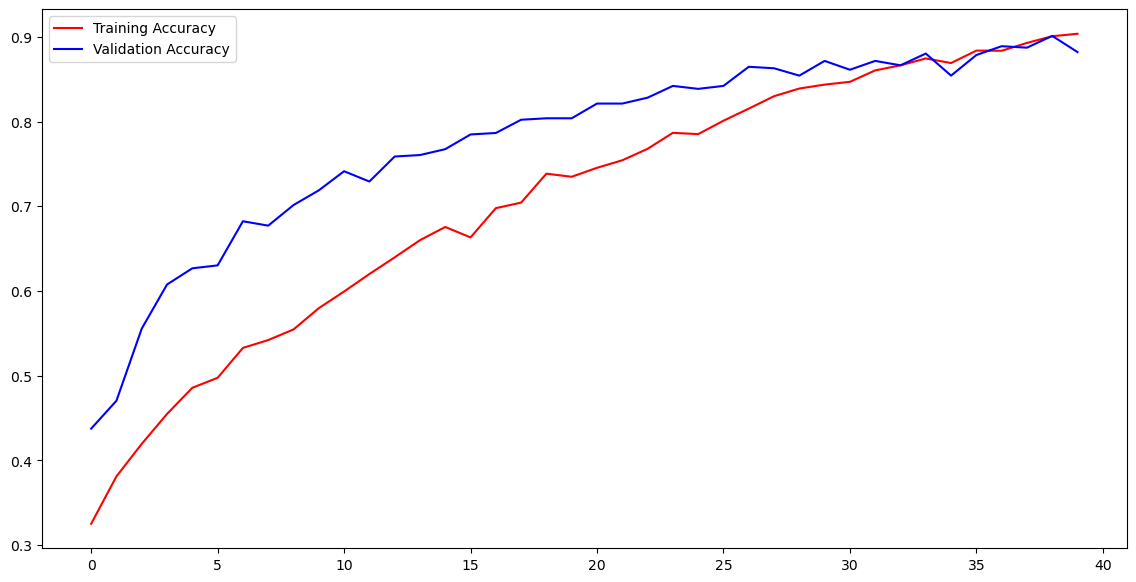

In [19]:
acc = final1.history['accuracy']
val_acc = final1.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

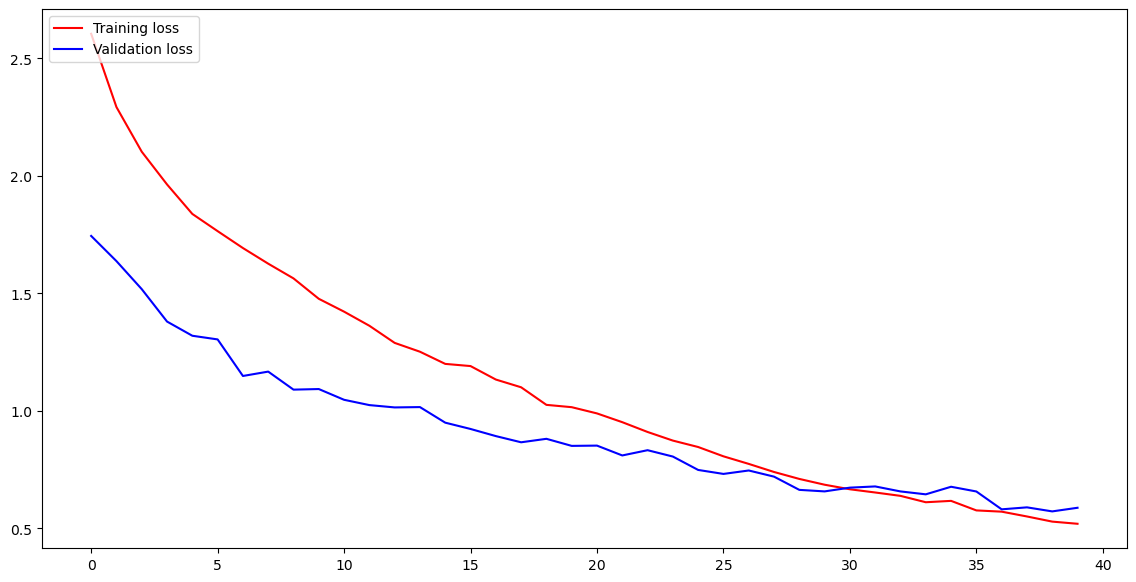

In [20]:
loss = final1.history['loss']
val_loss = final1.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

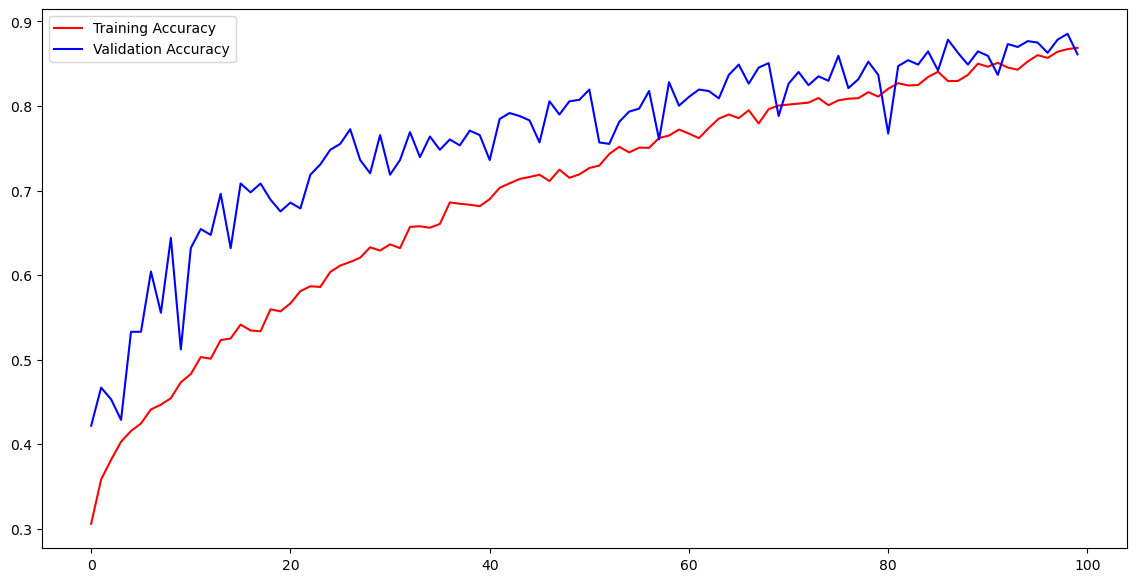

In [21]:
acc = final2.history['accuracy']
val_acc = final2.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

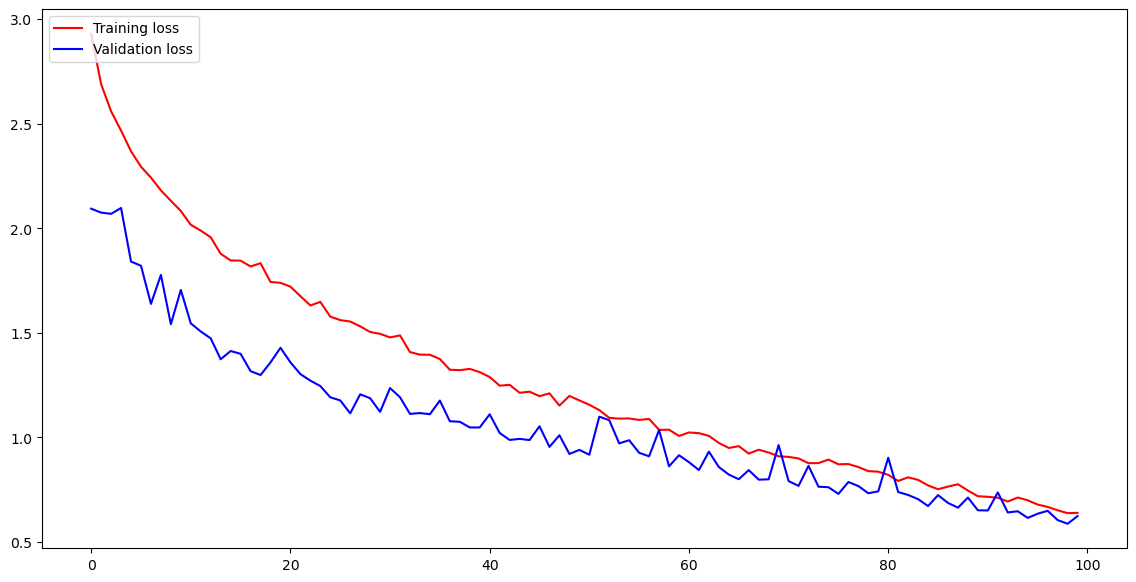

In [22]:
loss = final2.history['loss']
val_loss = final2.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

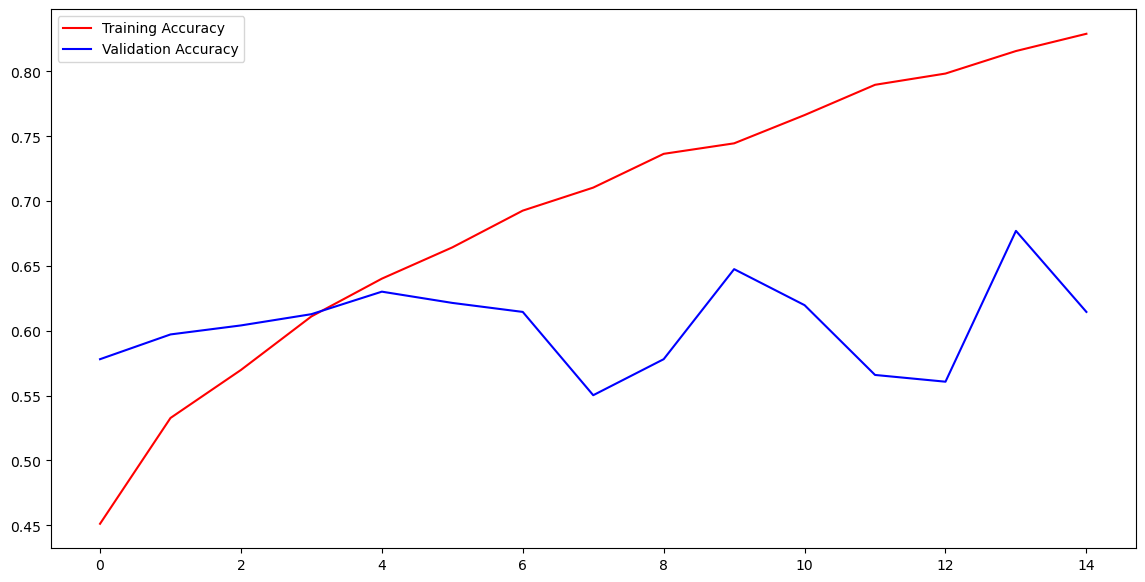

In [23]:
acc = final_mob.history['accuracy']
val_acc = final_mob.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

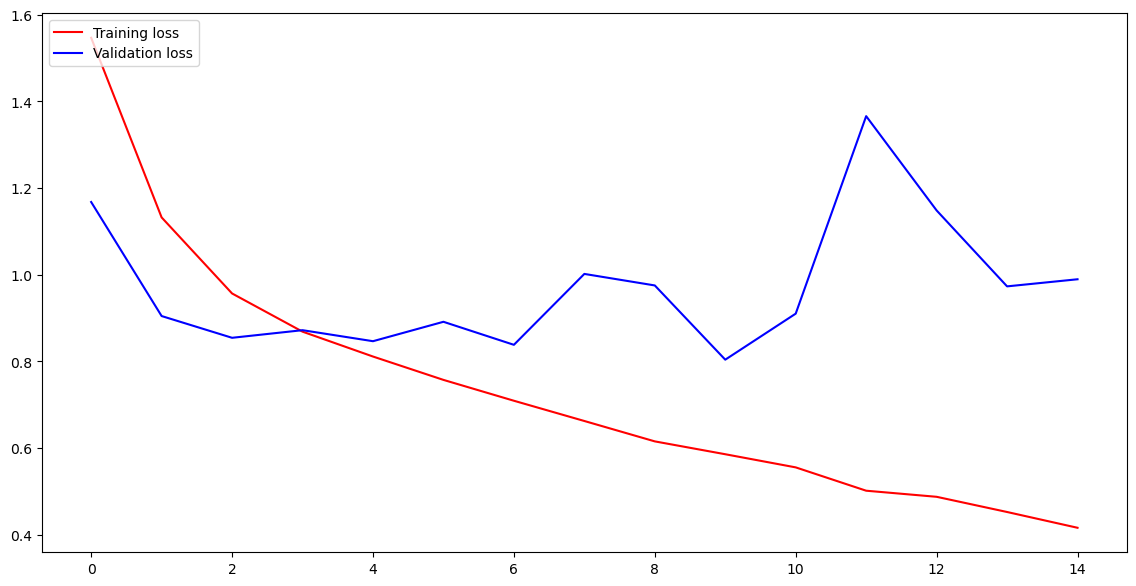

In [24]:
loss = final_mob.history['loss']
val_loss = final_mob.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [25]:
img = cv2.imread('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [26]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

Example Prediction

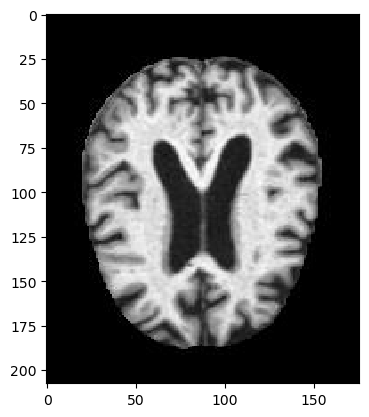

In [27]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
plt.imshow(img,interpolation='nearest')
plt.show()